# 1. Attempt to predict ratings using reviews using FastText embeddings

In [ ]:
import nltk.data
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score

In [ ]:
import nltk
nltk.download('punkt')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv( "/content/drive/My Drive/CSE 6240 Project Materials/Data/Avondale_Restaurant_Review.csv", delimiter=",", engine='python')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def clean_review(review, remove_stopwords = False):
    """Helper function to clean the reviews i.e. to convert a document to a sequence of words.
     Please note that we're not removing stopwords since word2vec relies on the broader context
     of the sentence in order to produce high-quality word vectors.

     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    cleaned_review = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        cleaned_review = [w for w in cleaned_review if not w in stops]


    #####################

    return cleaned_review

In [ ]:
def review_to_sentences( review: str, tokenizer: nltk.tokenize.punkt.PunktSentenceTokenizer ):
    """Helper function to split a review into parsed sentences. Returns a
     list of sentences, where each sentence is a list of words.

     Arg: review: review string (str)
          tokenizer: punkt tokenizer
     Returns:
          review_sentences: List of list of tokens.
                            e.g. [["word2vec", "was", "introduced", "by", "google" ],["it","leverages","distributed","token","representations"]]

     You should carry out the following steps.
     1. Use the tokenizer to split the paragraph into sentences.
     2. Clean the sentence to return a list of words for each sentence using the helper funtion above.
     3. Return a list of tokenized sentences.
    """
    ### Add your code here.
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    review_sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            review_sentences.append(clean_review(raw_sentence))
    ######################

    return review_sentences

In [ ]:
sentences = []
for review in train["text"]:
    sentences += review_to_sentences(review, tokenizer)

## 1.1. Approach 1: Using "bag of centroids" approach  as shown in HW2

In [ ]:
from gensim.models import FastText

def generate_z(sentences):
    model = FastText(sentences, size=100, window=5, min_count=5, workers=4,sg=1)
    word_list = list(model.wv.vocab)
    z=np.array([model[word] for word in word_list])

    return model, z, word_list

In [ ]:
model, z, word_list = generate_z(sentences)


### 1.1.1. Choosing Optimum number of clusters for "bag of centroids"

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
distortions = []
K = range(1,35)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(z)
    kmeanModel.fit(z)
    distortions.append(sum(np.min(cdist(z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / z.shape[0])

# Plot the elbow
plt.plot(K, distortions, '.')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

KeyboardInterrupt: ignored

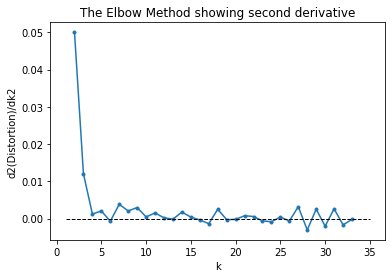

In [ ]:
# d2d_dk2=[]
# for i in range(1, len(K)-1):
#   d2d_dk2.append(distortions[i+1]+distortions[i-1]-2*distortions[i])
plt.plot(K[1:-1], d2d_dk2, '.-')
plt.xlabel('k')
plt.ylabel('d2(Distortion)/dk2')
plt.plot([1,35], [0, 0], linewidth=1, linestyle='--', color='black')
plt.title('The Elbow Method showing second derivative')
plt.show()

Based on elbow-method, using 10 clusters seems optimal.

In [ ]:
def fit_kmeans(z,word_list_z,num_clusters = 10):
    """ Fit kmeans on the embedding representations and return a mapping of word to cluster indices. Please use the default values for
        the rest of the kmeans parameters.

        Arg: z: word embeddings (ndarray)
              word_list_z: List of tokens in the model (List)
              num_clusters: Number of clusters (int)
        Returns:
            pre_trained_word2vec_model: word2vec model trained on the tokenized sentences.
            z2: word embeddings (ndarray)
            word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)

    """
    idx = KMeans(n_clusters = num_clusters).fit_predict(z)
    word_centroid_map_z = dict(zip(word_list_z, idx))
    ######################

    return word_centroid_map_z

In [ ]:
word_centroid_map = fit_kmeans(z, word_list, 10)

In [ ]:
def print_clusters(word_centroid_map, model_name):
    """ Print max(20, cluster_size) words for each of the clusters.

        Args: word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)
              model_name: Model Name (str)


    """
    print("The clusters for {0} are....".format(model_name))
    clust=[]
    for i in range(10):
      clust.append([])
    for key, value in word_centroid_map.items():
      clust[value].append(key)

    for i in range(10):
      chr=[]
      for j in range(20):
        try:
          chr.append(clust[i][j])
        except IndexError:
          break
      print('cluster', i+1, ':', chr)
print_clusters(word_centroid_map, "fastText")

In [ ]:
user_details = train[['user_id', 'text']].groupby(['user_id']).sum()
restaurant_details = train[['business_id', 'text']].groupby(['business_id']).sum()

In [ ]:
def create_bag_of_centroids(review, word_centroid_map, num_clusters = 10):

    count=np.zeros(num_clusters)
    for token in review:
      try:
        count[word_centroid_map[token]]+=1
      except KeyError:
        continue

    return count

In [ ]:
import nltk
nltk.download('stopwords')
def normalize(vec):
  tot=0
  for i in vec:
    tot+=i**2
  tot=tot**.5
  if tot>0:
    return [i/tot for i in vec]
  else:
    return vec

user_profile=[]
num_reviews = user_details["text"].size
for i in range(num_reviews):
    cr=clean_review(user_details["text"][i], remove_stopwords = True)
    user_profile.append(create_bag_of_centroids(cr, word_centroid_map, 10))

restaurant_profile=[]
num_reviews = restaurant_details["text"].size
for i in range(num_reviews):
    cr=clean_review(restaurant_details["text"][i], remove_stopwords = True)
    restaurant_profile.append(create_bag_of_centroids(cr, word_centroid_map, 10))


In [ ]:
user_details.insert(1, "profile_vector", user_profile, True)
restaurant_details.insert(1, "profile_vector", restaurant_profile, True)

In [ ]:
num_reviews = train["text"].size
X=[]
for i in range(num_reviews):
  u_vec=list(user_details.loc[train['user_id'][i]].profile_vector)
  r_vec=list(restaurant_details.loc[train['business_id'][i]].profile_vector)

  X.append(u_vec+r_vec)

X = np.array(X)

In [ ]:
y = train['stars'].as_matrix()

# 1.1.2. Predicting ratings 1-5

In [ ]:
def split(X, label):
    x_train, x_test, y_train, y_test = train_test_split(X, label, test_size = 0.2, random_state=0)
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = split(X, y)

In [ ]:
from warnings import filterwarnings
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import random as rd
filterwarnings('ignore')
import time

def calculateF1(X, y, k = 5):
    rd.seed(0) #Setting a common seed
    start=time.time()
    c_list=[10**i for i in np.random.uniform(-4, 4, 30)]
    f1_list=[]
    kf = KFold(n_splits=k)
    print('itr# Time')
    i=0
    for c in c_list:
        f1score=0.0
        i+=1
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = LogisticRegression(C=c)
            clf = clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            f1score+=f1_score(y_test, y_pred_test, average='weighted')/float(k)
        f1_list.append(f1score)
        if i%5==0:
            print(i, time.time()-start)

    return c_list, f1_list

In [ ]:
def findBestC(X, y, k = 5):
    c_list, f1_list = calculateF1(X, y, k)
    f1max = max(f1_list)
    c_best = c_list[f1_list.index(f1max)]
    improvement = f1max - min(f1_list)
    return c_best,improvement

In [ ]:
def findImprovement(X,train_sentiment,test_size = 0.2, random_state = 0):
    X_train, X_test, y_train, y_test = train_test_split(X, train_sentiment, test_size=test_size, random_state=random_state)
    c_best, improvement = findBestC(X_train, y_train)
    clf = LogisticRegression(C=c_best)
    clf = clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    f1_s = f1_score(y_test, y_pred_test, average='weighted')

    return c_best,improvement,f1_s

In [ ]:
c_best,improvement,f1_s = findImprovement(x_train, y_train)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

In [ ]:
from sklearn.model_selection import learning_curve
training_instances = list(range(1000, 9000, 1000))
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(C=c_best), x_train, y_train, train_sizes=training_instances, cv=5, random_state=0)
plt.plot(training_instances, [sum(i)/len(i) for i in valid_scores], marker='o', label='Cross-validation Accuracy')
plt.plot(training_instances, [sum(i)/len(i) for i in train_scores], marker='o', label='Training Accuracy')
plt.legend()
plt.ylim([0,1])
s=x_train.shape[0]
plt.xlabel('Percentage of Training Instances')
plt.xticks(tuple([s*i/10.0 for i in range(1, 9)]), tuple(range(10, 90, 10)))
plt.ylabel('Accuracy')
plt.title('Learning Curve: Bag of Centroids: Logistic Regression')
plt.show()

In [ ]:
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
# neigh = KNeighborsRegressor(n_neighbors=2)
# neigh.fit(x_train, y_train)
# y_test_pred = neigh.predict(x_test)
# rmse = mean_squared_error(y_test, y_test_pred, squared=False)
# rmse

clf = LogisticRegression(C=c_best)
clf = clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f1)
# plt.scatter(y_test, y_test_pred)
# plt.xlabel('Rating')
# plt.ylabel('Predicted Rating')
# plt.title('Rating prediction: Using SVR')
# plt.show()

In [ ]:
y_train_1=y_train[:]
y_train_1[y_train_1<5] = 0
y_train_1[y_train_1==5] = 1
c_best_1,improvement,f1_s = findImprovement(x_train, y_train_1)
print('best c:', c_best_1, '; improvement:', improvement, '; test f1_score:', f1_s)

### 1.1.3. Using 0 and 1 ratings (5 stars=1, less than 5=0)



In [ ]:
y_test_1=y_test[:]
y_test_1[y_test_1<5] = 0
y_test_1[y_test_1==5] = 1
clf = LogisticRegression(C=c_best_1)
clf = clf.fit(x_train, y_train_1)
y_test_pred = clf.predict(x_test)
f1 = f1_score(y_test_1, y_test_pred, average='weighted')
print(f1)

## 1.2. Approach 2: Using Average of vector representation of words in review text to predict ratings

In [ ]:
def text2vec(model, text):
  n=0
  vec=np.zeros(100)
  for token in cr:
    try:
      v=model[token]
    except KeyError:
      continue
    n+=1.0
    for i in range(vec.shape[0]):
        vec[i]+=v[i]
  if n>0:
    for i in range(vec.shape[0]):
      vec[i]/=n
  return vec

### 1.2.1. Predicting ratings 1-5

In [ ]:
X1=[]
num_reviews = train["text"].size
for i in range(num_reviews):
  n=0
  cr=clean_review(train["text"][i], remove_stopwords = True)
  X1.append(text2vec(model, cr))
X1=np.array(X1)

In [ ]:
x1_train, x1_test, y_train, y_test = split(X1, y)

In [ ]:
c_best,improvement,f1_s = findImprovement(x1_train, y_train)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

In [ ]:
training_instances = list(range(1000, 9000, 1000))
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(C=c_best), x1_train, y_train, train_sizes=training_instances, cv=5, random_state=0)
plt.plot(training_instances, [sum(i)/len(i) for i in valid_scores], marker='o', label='Cross-validation Accuracy')
plt.plot(training_instances, [sum(i)/len(i) for i in train_scores], marker='o', label='Training Accuracy')
plt.legend()
plt.ylim([0,1])
s=x1_train.shape[0]
plt.xlabel('Percentage of Training Instances')
plt.xticks(tuple([s*i/10.0 for i in range(1, 9)]), tuple(range(10, 90, 10)))
plt.ylabel('Accuracy')
plt.title('Learning Curve: Mean Representation: Logistic Regression')
plt.show()

In [ ]:
clf = LogisticRegression(C=c_best)
clf = clf.fit(x1_train, y_train)
y_test_pred = clf.predict(x1_test)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f1)

### 1.2.2. Using 0 and 1 ratings (5 stars=1, less than 5=0)

In [ ]:
y_train_1=y_train[:]
y_train_1[y_train_1<5] = 0
y_train_1[y_train_1==5] = 1
c_best_1,improvement,f1_s = findImprovement(x1_train, y_train_1)
print('best c:', c_best_1, '; improvement:', improvement, '; test f1_score:', f1_s)

In [ ]:
y_test_1=y_test[:]
y_test_1[y_test_1<5] = 0
y_test_1[y_test_1==5] = 1
clf = LogisticRegression(C=c_best_1)
clf = clf.fit(x1_train, y_train_1)
y_test_pred = clf.predict(x1_test)
f1 = f1_score(y_test_1, y_test_pred, average='weighted')
print(f1)

## 1.3. Approach 3: Making user/ restaurant profile with reviews and predicting ratings using that

Creating user and restaurant review profiles...

In [ ]:
user_profile1=[]
num_reviews = user_details["text"].size
for i in range(num_reviews):
    cr=clean_review(user_details["text"][i], remove_stopwords = True)
    user_profile1.append(text2vec(model, cr))

restaurant_profile1=[]
num_reviews = restaurant_details["text"].size
for i in range(num_reviews):
    cr=clean_review(restaurant_details["text"][i], remove_stopwords = True)
    restaurant_profile1.append(text2vec(model, cr))

In [ ]:
user_details.insert(1, "profile_vector1", user_profile1, True)
restaurant_details.insert(1, "profile_vector1", restaurant_profile1, True)

### 1.3.1. Predicting ratings 1-5

In [ ]:
num_reviews = train["text"].size
X2=[]
for i in range(num_reviews):
  u_vec=list(user_details.loc[train['user_id'][i]].profile_vector1)
  r_vec=list(restaurant_details.loc[train['business_id'][i]].profile_vector1)

  X2.append(u_vec+r_vec)

X2 = np.array(X2)

x2_train, x2_test, y_train, y_test = split(X2, y)

In [ ]:
c_best,improvement,f1_s = findImprovement(x2_train, y_train)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

In [ ]:
training_instances = list(range(1000, 9000, 1000))
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(C=c_best), x2_train, y_train, train_sizes=training_instances, cv=5, random_state=0)
plt.plot(training_instances, [sum(i)/len(i) for i in valid_scores], marker='o', label='Cross-validation Accuracy')
plt.plot(training_instances, [sum(i)/len(i) for i in train_scores], marker='o', label='Training Accuracy')
plt.legend()
plt.ylim([0,1])
s=x2_train.shape[0]
plt.xlabel('Percentage of Training Instances')
plt.xticks(tuple([s*i/10.0 for i in range(1, 9)]), tuple(range(10, 90, 10)))
plt.ylabel('Accuracy')
plt.title('Learning Curve: Assoc: Logistic Regression')
plt.show()

In [ ]:
clf1 = LogisticRegression(C=c_best)
clf1 = clf1.fit(x2_train, y_train)
y_test_pred = clf1.predict(x2_test)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f1)

### 1.3.2. Using 0 and 1 ratings (5 stars=1, less than 5=0)

In [ ]:
y_train_1=y_train[:]
y_train_1[y_train_1<5] = 0
y_train_1[y_train_1==5] = 1
c_best_1,improvement,f1_s = findImprovement(x2_train, y_train_1)
print('best c:', c_best_1, '; improvement:', improvement, '; test f1_score:', f1_s)

In [ ]:
y_test_1=y_test[:]
y_test_1[y_test_1<5] = 0
y_test_1[y_test_1==5] = 1
clf = LogisticRegression(C=c_best_1)
clf = clf.fit(x2_train, y_train_1)
y_test_pred = clf.predict(x2_test)
f1 = f1_score(y_test_1, y_test_pred, average='weighted')
print(f1)

#2. Train KNN model for item-based collaborative filtering

In [ ]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
#from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [ ]:
df_restaurants = pd.read_csv( "/content/drive/My Drive/CSE 6240 Project Materials/Data/Avondale_Restaurant_Review.csv", delimiter=",", engine='python',
                        usecols=['business_id', 'restaurant_name'],dtype={'business_id': 'str', 'restaurant_name': 'str'} )

df_ratings = pd.read_csv(
    "/content/drive/My Drive/CSE 6240 Project Materials/Data/Avondale_Restaurant_Review.csv", delimiter=",", engine='python',
    usecols=['user_id', 'business_id', 'stars'],
    dtype={'user_id': 'str', 'business_id': 'str', 'stars': 'float32'})

In [ ]:
df_restaurant_cnt = pd.DataFrame(df_ratings.groupby('business_id').size(), columns=['count'])
df_restaurant_cnt.head()

In [ ]:
popularity_thres = 50
popular_restaurants = list(set(df_restaurant_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_restaurants = df_ratings[df_ratings.business_id.isin(popular_restaurants)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular restaurants: ', df_ratings_drop_restaurants.shape)

In [ ]:
df_users_cnt = pd.DataFrame(df_ratings.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

In [ ]:
# filter data
ratings_thres = 1
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_restaurants[df_ratings_drop_restaurants.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular restaurants and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
df_ratings_drop_users

In [ ]:
df_restaurants=df_restaurants.drop_duplicates()

In [ ]:
df_ratings_drop_users=df_ratings_drop_users.drop_duplicates(['business_id','user_id'],keep= 'last')

# Train KNN model for item-based collaborative filtering¶

In [ ]:
restaurant_user_mat = df_ratings_drop_users.pivot(index='business_id', columns='user_id', values='stars').fillna(0)
restaurant_to_idx = {
    restaurant: i for i, restaurant in
    enumerate(list(df_restaurants.set_index('business_id').loc[restaurant_user_mat.index].restaurant_name))
}
# transform matrix to scipy sparse matrix
restaurant_user_mat_sparse = csr_matrix(restaurant_user_mat.values)

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(restaurant_user_mat_sparse)


In [ ]:
!pip install fuzzywuzzy

from fuzzywuzzy import fuzz

In [ ]:
def fuzzy_matching(mapper, fav_rest, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None

    Parameters
    ----------
    mapper: dict, map restaurants  name to index of the restaurants in data

    fav_rest: str, name of user input restaurant

    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_rest.lower())
        if ratio >= 40:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    # if not match_tuple:
    #     print('Oops! No match is found')
    #     return
    # if verbose:
    #     print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_rest, n_recommendations):
    """
    return top n similar restaurant recommendations based on user's input restaurant
    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: restaurant-user matrix

    mapper: dict, map restaurant title name to index of the restaurant in data

    fav_rest: str, name of user input restaurant

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar restaurant recommendations
    """
    # fit
    model_knn.fit(data)
    # get input restaurant index
    print('You have input restaurant:', fav_rest)
    idx = fuzzy_matching(mapper, fav_rest, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    final_list=[]
    # print recommendations
    print('Recommendations for {}:'.format(fav_rest))
    for i, (idx, dist) in enumerate(raw_recommends):
        final_list.append([reverse_mapper[idx], df_restaurants[df_restaurants['restaurant_name']==reverse_mapper[idx]].iloc[0]['business_id'],dist])
        #print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
    return final_list

# 3. Using "Approach 3" for rating prediction on restaurants recommended by built kNN model for item based collaborative filtering

In [ ]:
userID='uFVAAe0JC81IPmxgT49Hcw'
my_favorite = 'Chipotle'
reco_list = make_recommendation(
    model_knn=model_knn,
    data=restaurant_user_mat_sparse,
    fav_rest=my_favorite,
    mapper=restaurant_to_idx,
    n_recommendations=20)

rest_list=[]
for i in reco_list:
  u_vec=list(user_details.loc[userID].profile_vector1)
  r_vec=list(restaurant_details.loc[i[1]].profile_vector1)
  ypred = clf1.predict(np.array([u_vec+r_vec]))[0]
  rest_list.append([i[0], i[2], ypred, i[2]*ypred])

rest_list.sort(key = lambda x: x[3], reverse = True)
Restaurants = pd.DataFrame(rest_list, columns=['Name', 'Distance[relevance]', 'Pred_Rating[fondness]', 'Hybrid_Rating'])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(Restaurants)

In [ ]:
'''
5 130.1011106967926
10 183.21846723556519
15 288.89422726631165
20 400.05343294143677
25 508.1445879936218
30 588.5044627189636

5 20.081361770629883
10 34.606168031692505
15 48.47834086418152
20 65.34998774528503
25 82.71624112129211
30 102.73631262779236

5 334.58515644073486
10 466.0214009284973
15 682.3025321960449
20 1006.7462565898895
25 1200.6035027503967
30 1453.2643547058105

5 23.567090034484863
10 47.91888642311096
15 68.41130590438843
20 89.56526565551758
25 117.69877004623413
30 139.29775094985962

'''
import matplotlib.pyplot as plt

z=[130.1011106967926, 183.21846723556519, 288.89422726631165, 400.05343294143677, 508.1445879936218, 588.5044627189636]
z1=[20.081361770629883, 34.606168031692505, 48.47834086418152, 65.34998774528503, 82.71624112129211, 102.73631262779236]
y=[334.58515644073486, 466.0214009284973, 682.3025321960449, 1006.7462565898895, 1200.6035027503967, 1453.2643547058105]
y1=[23.567090034484863, 47.91888642311096, 68.41130590438843, 89.56526565551758, 117.69877004623413, 139.29775094985962]
plt.plot(range(5, 31, 5), z, label='Baseline 1: SVM')
plt.plot(range(5, 31, 5), z1, label='Baseline 2: LR')
plt.plot(range(5, 31, 5), y, label='SVM')
plt.plot(range(5, 31, 5), y1, label='Logistic Regression')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Computation Time [s]')
plt.title('Runtime Comparison with Baselines')
plt.show()


In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=['SVM', 'Logis-Reg'],
                           n=[55.3, 58.3], m=[51.05, 52.5]))

ind = np.arange(len(df))
width = 0.25
fig, ax = plt.subplots(figsize=(4, 1))
ax.barh(ind+width, df.n, width, color='blue', label='Baseline')
ax.barh(ind, df.m, width, color='green', label='Our Approach')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(loc='center', bbox_to_anchor=(1.3, 0),
          fancybox=True, shadow=True, ncol=1)
plt.xlabel('Test Accuracy (%)')
plt.xlim([0, 101])

plt.show()

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!df -h